<a href="https://colab.research.google.com/github/andrigerber/RecommenderSystemsColab/blob/main/V1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis (EDA) Pipeline Documentation

This document outlines the structure and functionality of a modular EDA pipeline designed for large-scale datasets. The code is organized into three primary components: **DataLoader**, **DataPreprocessor**, and **DataEDA**. The pipeline is compatible with both training and test datasets, ensuring flexibility and scalability.

---

In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from google.colab import drive
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Ensure that plots are displayed inline in Colab/Jupyter Notebooks
%matplotlib inline

# =============================================================================
# DataLoader: Loading the raw data from a CSV file
# =============================================================================
class DataLoader:
    def __init__(self, file_path: str):
        """
        Initializes the DataLoader with the path to the CSV file.

        :param file_path: Path to the CSV file
        """
        self.file_path = file_path

    def load_data(self) -> pd.DataFrame:
        """
        Mounts Google Drive (if in Colab) and loads the CSV file.
        Returns the loaded DataFrame.

        :return: DataFrame containing the raw data
        """
        # Mount Google Drive (only needed in Colab)
        drive.mount('/content/drive', force_remount=True)

        if not os.path.exists(self.file_path):
            raise FileNotFoundError(f"File not found: {self.file_path}")

        df = pd.read_csv(self.file_path)
        print(f"File '{self.file_path}' loaded successfully. Shape: {df.shape}")
        return df

# =============================================================================
# DataPreprocessor: Converting and cleaning the raw data (just for EDA)
# =============================================================================
class DataPreprocessor:
    def __init__(self, df: pd.DataFrame, is_train: bool = True):
        """
        Initializes the Preprocessor with a DataFrame.

        :param df: DataFrame to be preprocessed.
        :param is_train: Boolean indicating whether the data is training data (contains the target variable).
        """
        self.df = df.copy()
        self.is_train = is_train

    def convert_data_types(self) -> pd.DataFrame:
        """
        Converts important columns to the correct data types.
        - Converts 'ts_listen' (UNIX time) to datetime.
        - Converts 'release_date' (format YYYYMMDD) to datetime and removes rows with invalid data.
        - Converts ID columns to the 'category' data type.
        - Converts other relevant columns to 'category' or 'bool'.

        :return: The preprocessed DataFrame
        """
        # 1. Convert 'ts_listen' (if present)
        if 'ts_listen' in self.df.columns:
            self.df['ts_listen'] = pd.to_datetime(self.df['ts_listen'], unit='s', errors='coerce')

        # 2. Convert 'release_date' (if present) in format YYYYMMDD and remove rows with invalid data
        if 'release_date' in self.df.columns:
            self.df['release_date'] = pd.to_datetime(self.df['release_date'], format='%Y%m%d', errors='coerce')
            self.df = self.df.dropna(subset=['release_date'])

        # 3. Convert important ID columns to category
        cat_cols = ['genre_id', 'media_id', 'album_id', 'user_id', 'artist_id']
        for col in cat_cols:
            if col in self.df.columns:
                self.df[col] = self.df[col].astype('category')

        # 4. Convert additional columns to category: context_type, platform_name, platform_family, listen_type
        additional_cat = ['context_type', 'platform_name', 'platform_family', 'listen_type']
        for col in additional_cat:
            if col in self.df.columns:
                self.df[col] = self.df[col].astype('category')

        # 5. Convert 'user_gender' to bool (if present)
        if 'user_gender' in self.df.columns:
            self.df['user_gender'] = self.df['user_gender'].astype('bool')

        # 6. Convert target variable 'is_listened' to bool, if training data and column is present
        if self.is_train and 'is_listened' in self.df.columns:
            self.df['is_listened'] = self.df['is_listened'].astype('bool')

        print("=== Data type conversion completed ===")
        print("New data types:")
        print(self.df.dtypes)
        return self.df

    def remove_duplicates(self, drop: bool = True) -> pd.DataFrame:
        """
        Checks and removes duplicates in the DataFrame.

        :param drop: If True, duplicates will be removed.
        :return: DataFrame without duplicates (if drop=True)
        """
        dup_count = self.df.duplicated().sum()
        print(f"Number of duplicates before cleaning: {dup_count}")
        if dup_count > 0 and drop:
            self.df = self.df.drop_duplicates()
            print(f"Duplicates removed. New shape: {self.df.shape}")
        return self.df

class DataEDA:
    def __init__(self, df, dataset_name="Dataset"):
        self.df = df.copy()
        self.dataset_name = dataset_name

    def overview(self):
        # Print an overview of the converted DataFrame:
        print(f"=== {self.dataset_name} Data Overview (Converted) ===")
        print("Shape:", self.df.shape)
        print("Columns:", self.df.columns.tolist())
        print("\nStatistical summary (numeric, converted):")
        print(self.df.describe())

    def analyze_missing_values(self):
        # Analyze missing values based on the converted DataFrame:
        print("=== Missing Values (after conversion) ===")
        missing = self.df.isnull().sum()
        missing = missing[missing > 0]
        if missing.empty:
            print("No missing values found.")
        else:
            print(missing.to_string())

    def check_duplicates(self, drop=False):
        # Check and print the number of duplicates, optionally remove them:
        dup_count = self.df.duplicated().sum()
        print("=== Duplicate Analysis ===")
        if dup_count == 0:
            print("No duplicates found.")
        else:
            print(f"Number of duplicates: {dup_count}")
            print("Example duplicates:")
            print(self.df[self.df.duplicated()].head())
            if drop:
                self.df = self.df.drop_duplicates()
                print("Duplicates have been removed. New shape:", self.df.shape)

    def sturges_bins(self, data):
        """
        Calculates the optimal number of bins for a histogram using Sturges' rule.
        """
        n = len(data)
        bins = int(np.ceil(np.log2(n))) + 1
        return bins

    def plot_numeric_features(self):
        """Plots histograms and boxplots for numeric features with adaptive bin count."""
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        for col in numeric_cols:
            data = self.df[col].dropna()
            bins = self.sturges_bins(data)

            plt.figure(figsize=(8, 4))
            sns.histplot(data, bins=bins, kde=True, color='skyblue')
            plt.title(f"Histogram of {col} (bins={bins})")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.show()

            plt.figure(figsize=(8, 4))
            sns.boxplot(x=data, color='lightgreen')
            plt.title(f"Boxplot of {col}")
            plt.xlabel(col)
            plt.show()

    def plot_categorical_features(self, threshold=20):
        """Plots the top categories for selected categorical features.

        If the number of unique categories exceeds the threshold,
        only the top `min(threshold, N)` categories are displayed.
        """
        potential_cat = ['genre_id', 'user_gender', 'media_id', 'album_id',
                         'artist_id', 'context_type', 'platform_name',
                         'listen_type', 'platform_family', 'user_id']
        for col in potential_cat:
            if col in self.df.columns:
                plt.figure(figsize=(10, 4))
                unique_count = self.df[col].nunique()
                # Determine the number to display: if unique_count < threshold, use unique_count, otherwise threshold
                max_cat = min(threshold, unique_count)
                order = self.df[col].value_counts().index[:max_cat]
                sns.countplot(y=self.df[col], order=order, palette='viridis')
                plt.title(f"Top {max_cat} (of {unique_count}) categories for {col}")
                plt.xlabel("Count")
                plt.ylabel(col)
                plt.show()

    def plot_joint_analysis(self, x_col=None, y_col=None, sample_size=100000):
        """
        Creates a jointplot that combines the distributions of two numeric features
        (as marginal histograms) with a scatterplot and a regression line.

        If x_col and y_col are not provided, the function automatically selects
        the first two numeric columns.

        The true correlation is calculated over the entire dataset,
        while a uniform sample (sample_size) is used for the plot.
        """
        # Find all numeric columns in the DataFrame
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()

        # If x_col or y_col are not specified, choose the first two numeric columns
        if x_col is None or y_col is None:
            if len(numeric_cols) < 2:
                print("Not enough numeric columns available for a jointplot.")
                return
            else:
                x_col, y_col = numeric_cols[:2]

        # Calculate the true correlation over the entire dataset
        true_corr = self.df[[x_col, y_col]].corr().iloc[0, 1]

        # Take a uniform sample for the plot if the dataset is very large
        if len(self.df) > sample_size:
            df_sample = self.df.sample(n=sample_size, random_state=42)
            print(f"Using a uniform sample of {sample_size} rows for the plot.")
        else:
            df_sample = self.df

        # Create the jointplot with regression based on the sample
        g = sns.jointplot(data=df_sample, x=x_col, y=y_col, kind='reg', height=8,
                          scatter_kws={'s': 30}, line_kws={'color': 'red'})

        # Add the true correlation as an annotation
        g.ax_joint.annotate(f"r = {true_corr:.2f}", xy=(0.05, 0.95), xycoords="axes fraction",
                            fontsize=12, fontweight='bold', color='black')

        plt.suptitle(f"Joint Analysis: {x_col} vs. {y_col}", y=1.02)
        plt.show()

    def temporal_analysis(self, cutoff_year=2015):
        """Extended analysis of the temporal aspects in the dataset with a cutoff."""
        if 'ts_listen' in self.df.columns:
            self.df['listen_date'] = pd.to_datetime(self.df['ts_listen'].dt.date)
            self.df['listen_hour'] = self.df['ts_listen'].dt.hour
            self.df['listen_weekday'] = self.df['ts_listen'].dt.day_name()

            # **Daily aggregation**
            df_daily = self.df.groupby('listen_date').size().reset_index(name='count')

            # **Monthly aggregation**
            df_monthly = df_daily.resample('M', on='listen_date').sum().reset_index()

            # **Calculate the start date and filter data**
            start_year = df_monthly['listen_date'].dt.year.min()
            removed_months = df_monthly[df_monthly['listen_date'].dt.year < cutoff_year].shape[0]

            # **Apply cutoff to remove irrelevant time periods**
            df_monthly = df_monthly[df_monthly['listen_date'].dt.year >= cutoff_year]

            # **Display monthly aggregated listening events**
            print(f"Monthly aggregated listening events from {cutoff_year} (start year: {start_year})")
            print(f"\033[91m🔴 {removed_months} months removed that were before {cutoff_year}.\033[0m\n")
            print(df_monthly.to_string(index=False))  # Print all rows without index

            # **Plot monthly usage trend**
            plt.figure(figsize=(12, 5))
            sns.barplot(data=df_monthly, x="listen_date", y="count", color="royalblue")
            plt.title(f"Monthly usage trend (from {cutoff_year})", fontsize=14)
            plt.xlabel("Month", fontsize=12)
            plt.ylabel("Number of listeners", fontsize=12)
            plt.xticks(rotation=45)
            plt.yscale("log")  # Logarithmic scale for better readability
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()

            # **Weekday distribution**
            plt.figure(figsize=(10, 4))
            sns.countplot(data=self.df, x="listen_weekday",
                          order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
                          palette="pastel")
            plt.title("Listening behavior by weekday", fontsize=14)
            plt.xlabel("Weekday", fontsize=12)
            plt.ylabel("Number of listening events", fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            plt.show()

            # **Heatmap: Listening behavior by hour and weekday**
            pivot_table = self.df.pivot_table(index="listen_weekday", columns="listen_hour", values="user_id", aggfunc="count")

            # **1. Normalization (logarithmic scaling for better readability)**
            pivot_table = np.log1p(pivot_table)  # log1p(x) = log(1 + x), avoids log(0) error

            # **2. Heatmap with optimized presentation**
            plt.figure(figsize=(12, 5))
            sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5, cbar_kws={"label": "Log(Number of users)"})
            plt.title("Listening behavior: Hour vs. Weekday (log-transformed)", fontsize=14)
            plt.xlabel("Hour", fontsize=12)
            plt.ylabel("Weekday", fontsize=12)
            plt.xticks(rotation=0)
            plt.yticks(rotation=0)
            plt.show()

        if 'release_date' in self.df.columns:
            self.df['release_year'] = self.df['release_date'].dt.year

            plt.figure(figsize=(12, 4))
            sns.histplot(self.df['release_year'].dropna(), bins=50, color='mediumpurple')
            plt.title("Distribution of release dates", fontsize=14)
            plt.xlabel("Year of release", fontsize=12)
            plt.ylabel("Count", fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            plt.show()

    def analyze_target_variable(self):
        """Visualizes the distribution of the target variable (is_listened)."""
        if 'is_listened' in self.df.columns:
            plt.figure(figsize=(8, 5))
            sns.countplot(data=self.df, x="is_listened", palette="Set2")
            plt.title("Distribution of target variable (is_listened)", fontsize=14)
            plt.xlabel("Was the track listened to?", fontsize=12)
            plt.ylabel("Number of entries", fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            plt.show()
        else:
            print("Column 'is_listened' not found in the DataFrame.")

    def sturges_bins(self, data):
        """
        Calculates the optimal number of bins for a histogram using Sturges' rule.
        """
        n = len(data)
        bins = int(np.ceil(np.log2(n))) + 1
        return bins

    def scott_bins(self, data):
        """
        Calculates the optimal number of bins for a histogram using Scott's rule.
        """
        bin_width = 3.5 * np.std(data) / np.cbrt(len(data))  # 3.5 * sigma / n^(1/3)
        bins = int(np.ceil((data.max() - data.min()) / bin_width))
        return max(bins, 5)  # At least 5 bins for readability

    def sqrt_bins(self, data):
        """
        Calculates the number of bins based on the square root of the sample size.
        """
        bins = int(np.sqrt(len(data)))
        return max(bins, 5)

    def freedman_diaconis_bins(self, data):
        """
        Calculates the optimal number of bins for a histogram using the Freedman-Diaconis rule.
        """
        iqr = np.subtract(*np.percentile(data, [75, 25]))  # Interquartile range
        bin_width = 2 * iqr / np.cbrt(len(data))  # 2 * IQR / n^(1/3)
        bins = int(np.ceil((data.max() - data.min()) / bin_width))
        return max(bins, 5)

    def rice_bins(self, data):
        """
        Calculates the optimal number of bins for a histogram using the Rice rule.
        """
        bins = int(2 * np.cbrt(len(data)))  # 2 * n^(1/3)
        return max(bins, 10)  # At least 10 bins for more detail

    def interaction_analysis(self, binning_method="sturges"):
        """Examines interaction behavior using different binning methods."""
        # Select the desired binning method
        if binning_method == "sturges":
            bin_func = self.sturges_bins
        elif binning_method == "scott":
            bin_func = self.scott_bins
        elif binning_method == "sqrt":
            bin_func = self.sqrt_bins
        elif binning_method == "freedman":
            bin_func = self.freedman_diaconis_bins
        elif binning_method == "rice":
            bin_func = self.rice_bins
        else:
            raise ValueError("Invalid binning method. Choose 'sturges', 'scott', 'sqrt' or 'freedman'.")

        if 'user_id' in self.df.columns and 'media_id' in self.df.columns:
            user_song_counts = self.df.groupby('user_id')['media_id'].count()
            bins = self.sturges_bins(user_song_counts)

            plt.figure(figsize=(12, 6))
            sns.histplot(user_song_counts, bins=bins, log_scale=(False, True), color='blue', edgecolor='black', element="bars")
            plt.title("Number of songs per user", fontsize=14)
            plt.xlabel("Songs per user (log scale)", fontsize=12)
            plt.ylabel("Number of users (log scale)", fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.show()
            print(f"📊 Average songs per user: {user_song_counts.mean():.2f}")

        if 'user_id' in self.df.columns and 'album_id' in self.df.columns:
            user_album_counts = self.df.groupby('user_id')['album_id'].nunique()
            bins = self.sturges_bins(user_album_counts)

            plt.figure(figsize=(12, 6))
            sns.histplot(user_album_counts, bins=bins, log_scale=(False, True), color='orange', edgecolor='black', element="bars")
            plt.title("Number of distinct albums per user", fontsize=14)
            plt.xlabel("Albums per user (log scale)", fontsize=12)
            plt.ylabel("Number of users (log scale)", fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.show()
            print(f"📊 Average albums per user: {user_album_counts.mean():.2f}")

        if 'user_id' in self.df.columns and 'artist_id' in self.df.columns:
            user_artist_counts = self.df.groupby('user_id')['artist_id'].nunique()
            bins = self.sturges_bins(user_artist_counts)

            plt.figure(figsize=(12, 6))
            sns.histplot(user_artist_counts, bins=bins, log_scale=(False, True), color='purple', edgecolor='black', element="bars")
            plt.title("Number of distinct artists per user", fontsize=14)
            plt.xlabel("Artists per user (log scale)", fontsize=12)
            plt.ylabel("Number of users (log scale)", fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.5)
            plt.show()
            print(f"📊 Average artists per user: {user_artist_counts.mean():.2f}")

    def analyze_platform_effect(self):
        """Compares listening behavior across different streaming platforms."""
        if 'platform_name' in self.df.columns and 'is_listened' in self.df.columns:
            plt.figure(figsize=(12, 5))
            sns.barplot(data=self.df, x="platform_name", y="is_listened", estimator=np.mean, palette="viridis")
            plt.title("Average listening probability per platform")
            plt.xlabel("Platform")
            plt.ylabel("P(Track listened)")
            plt.xticks(rotation=45)
            plt.show()

    def analyze_genre_effect(self):
        """Examines which genres are listened to or skipped more frequently."""
        if 'genre_id' in self.df.columns and 'is_listened' in self.df.columns:
            # Count how often each genre occurs
            genre_counts = self.df['genre_id'].value_counts()

            # Limit to the top 20 genres, marking all others as "Other"
            top_genres = genre_counts.index[:20]  # Take only the 20 most frequent genres
            self.df['genre_grouped'] = self.df['genre_id'].apply(lambda x: x if x in top_genres else 'Other')

            # Calculate the average listening probability for grouped genres
            genre_listened = self.df.groupby('genre_grouped')['is_listened'].mean().sort_values(ascending=False)

            plt.figure(figsize=(10, 8))
            sns.barplot(y=genre_listened.index, x=genre_listened.values, palette="magma")
            plt.title("Average listening probability per genre (Top 20 + Others)", fontsize=14)
            plt.xlabel("P(Track listened)", fontsize=12)
            plt.ylabel("Genre", fontsize=12)
            plt.show()

    def analyze_age_effect(self):
        """Examines the influence of age on listening behavior."""
        if 'user_age' in self.df.columns and 'is_listened' in self.df.columns:
            sns.boxplot(data=self.df, x="is_listened", y="user_age", palette="coolwarm")
            plt.title("Effect of age on listening behavior")
            plt.xlabel("Was the track listened to?")
            plt.ylabel("User's age")
            plt.show()

    def analyze_gender_effect(self):
        """Analyzes whether there are gender differences in listening behavior."""
        if 'user_gender' in self.df.columns and 'is_listened' in self.df.columns:
            sns.barplot(data=self.df, x="user_gender", y="is_listened", estimator=np.mean, palette="Set2")
            plt.title("Average listening probability by gender")
            plt.xlabel("Gender")
            plt.ylabel("P(Track listened)")
            plt.show()

    def analyze_time_effect(self):
        """
        Analyzes listening behavior by hour and weekday using bar plots
        to show average listening probability, which is clearer for a binary target.
        """
        if 'ts_listen' in self.df.columns and 'is_listened' in self.df.columns:
            self.df['listen_hour'] = self.df['ts_listen'].dt.hour
            self.df['listen_weekday'] = self.df['ts_listen'].dt.day_name()

            # Listening probability by hour
            hour_agg = self.df.groupby('listen_hour')['is_listened'].mean().reset_index()
            plt.figure(figsize=(12, 5))
            sns.barplot(data=hour_agg, x='listen_hour', y='is_listened', palette="coolwarm")
            plt.title("Listening Probability by Hour")
            plt.xlabel("Hour of the Day")
            plt.ylabel("P(Track listened)")
            plt.ylim(0, 1)
            plt.show()

            # Reorder weekdays: Monday -> Sunday
            weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
            self.df['listen_weekday'] = pd.Categorical(self.df['listen_weekday'], categories=weekday_order, ordered=True)

            # Listening probability by weekday
            weekday_agg = self.df.groupby('listen_weekday')['is_listened'].mean().reset_index()
            plt.figure(figsize=(10, 4))
            sns.barplot(data=weekday_agg, x='listen_weekday', y='is_listened', palette="pastel")
            plt.title("Listening Probability by Weekday")
            plt.xlabel("Weekday")
            plt.ylabel("P(Track listened)")
            plt.ylim(0, 1)
            plt.show()

    def analyze_media_duration_effect(self):
        """Shows the effect of song duration on listening behavior."""
        if 'media_duration' in self.df.columns and 'is_listened' in self.df.columns:
            sns.boxplot(data=self.df, x="is_listened", y="media_duration", palette="coolwarm")
            plt.title("Effect of song duration on listening behavior")
            plt.xlabel("Was the track listened to?")
            plt.ylabel("Song duration (seconds)")
            plt.show()

    def analyze_context_effect(self):
        """Examines whether users prefer listening to playlists, albums, or radio."""
        if 'context_type' in self.df.columns and 'is_listened' in self.df.columns:
            plt.figure(figsize=(12, 5))
            sns.barplot(data=self.df, x="context_type", y="is_listened", estimator=np.mean, palette="rocket")
            plt.title("Average listening probability by context")
            plt.xlabel("Context")
            plt.ylabel("P(Track listened)")
            plt.xticks(rotation=45)
            plt.show()
print("EDA module loaded successfully.")

EDA module loaded successfully.


---
## 1. Data Ingestion

### DataLoader
- **Purpose:**  
  To ingest raw data from a CSV file.

- **Key Features:**  
  - Automatically mounts Google Drive (in Colab environments) to access files.
  - Validates the file path and raises a descriptive error if the file is not found.
  - Reads the CSV file into a pandas DataFrame and prints the data shape for confirmation.
- **Usage Example:**  


In [ ]:
# Adjust the example file path to your directory
FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/train.csv"

# DataLoader: Load raw data
loader = DataLoader(file_path=FILE_PATH)
raw_df = loader.load_data()

Mounted at /content/drive
File '/content/drive/MyDrive/Colab Notebooks/train.csv' loaded successfully. Shape: (7558834, 15)


---
## 2. Data Preprocessing

### DataPreprocessor

**Purpose:**  
To clean and prepare raw data specifically for EDA.

**Key Features:**

- **Data Type Conversion:**
  - Converts UNIX timestamps (`ts_listen`) into datetime objects.
  - Parses `release_date` from the `YYYYMMDD` format and removes rows with invalid dates.
  - Casts key identifier columns (e.g., `genre_id`, `media_id`, etc.) to categorical types.
  - Converts additional columns such as `context_type` and `platform_name` to categorical and boolean types.

- **Duplicate Removal:**
  - Checks for and optionally removes duplicate rows to ensure data quality.



In [ ]:
# DataPreprocessor: Preprocess the data
preprocessor = DataPreprocessor(df=raw_df, is_train=True)
processed_df = preprocessor.convert_data_types()
processed_df = preprocessor.remove_duplicates(drop=True)

# Overview of the preprocessed data
print("\n=== Overview of preprocessed data ===")
print(processed_df.head())

=== Data type conversion completed ===
New data types:
genre_id                 category
ts_listen          datetime64[ns]
media_id                 category
album_id                 category
context_type             category
release_date       datetime64[ns]
platform_name            category
platform_family          category
media_duration              int64
listen_type              category
user_gender                  bool
user_id                  category
artist_id                category
user_age                    int64
is_listened                  bool
dtype: object
Number of duplicates before cleaning: 0

=== Overview of preprocessed data ===
  genre_id           ts_listen media_id album_id context_type release_date  \
0    25471 2016-12-01 13:00:15   222606    41774           12   2004-07-04   
1    25571 2016-11-30 22:25:35   250467    43941            0   2006-03-01   
2       16 2016-11-19 13:59:13   305197    48078            1   2014-07-14   
3        7 2016-11-26 09:21:38

- **Interpretation:**
 - No duplicates were found, which means the dataset is clean and ready for analysis.

**Data Dictionary for the Deezer Recommender System**  
For more details on this dataset, see the [Kaggle DSG17 Online Phase Data](https://www.kaggle.com/c/dsg17-online-phase/data).

| **Variable**       | **Data Type**     | **Description**                                                                              |
|--------------------|-------------------|----------------------------------------------------------------------------------------------|
| `genre_id`         | category          | Identifiant of the genre of the song                                                         |
| `ts_listen`        | datetime64[ns]    | Timestamp of the listening in UNIX time                                                      |
| `media_id`         | category          | Identifiant of the song listened by the user                                                 |
| `album_id`         | category          | Identifiant of the album of the song                                                         |
| `context_type`     | category          | Type of content where the song was listened (e.g., playlist, album, etc.)                      |
| `release_date`     | datetime64[ns]    | Release date of the song (format YYYYMMDD)                                                   |
| `platform_name`    | category          | Type of operating system                                                                     |
| `platform_family`  | category          | Type of device                                                                               |
| `media_duration`   | int64             | Duration of the song                                                                         |
| `listen_type`      | category          | Indicates if the song was listened in a flow or not                                          |
| `user_gender`      | bool              | Gender of the user                                                                           |
| `user_id`          | category          | Anonymized ID of the user                                                                    |
| `artist_id`        | category          | Identifiant of the artist of the song                                                        |
| `user_age`         | int64             | Age of the user                                                                              |
| `is_listened`      | bool              | 1 if the track was listened (over 30 sec), 0 otherwise                                       |


---
## 3. Exploratory Data Analysis (EDA)

### DataEDA

**Purpose:**  
To perform comprehensive data quality checks and visual analyses, offering insights into distributions, relationships, and trends.

**Key Methods and Functionalities:**

---

- **Overview and Quality Checks:**
  - `overview()`: Provides a summary of the DataFrame, including shape, columns, and statistical summaries.
  - `analyze_missing_values()`: Identifies and reports any missing data.
  - `check_duplicates()`: Analyzes duplicate entries, with the option to remove them.

In [ ]:
eda = DataEDA(df=processed_df, dataset_name="Train Data")
# Display an overview of the DataFrame
eda.overview()
# Analyze missing values
eda.analyze_missing_values()
# Duplicate analysis (without removing duplicates)
eda.check_duplicates(drop=False)

=== Train Data Data Overview (Converted) ===
Shape: (7558817, 15)
Columns: ['genre_id', 'ts_listen', 'media_id', 'album_id', 'context_type', 'release_date', 'platform_name', 'platform_family', 'media_duration', 'listen_type', 'user_gender', 'user_id', 'artist_id', 'user_age', 'is_listened']

Statistical summary (numeric, converted):
                           ts_listen                   release_date  \
count                        7558817                        7558817   
mean   2016-11-13 04:15:35.787582720  2011-11-21 04:03:28.365938432   
min              1970-01-01 00:00:01            1900-01-01 00:00:00   
25%              2016-11-06 19:27:50            2009-12-31 00:00:00   
50%              2016-11-13 17:12:01            2014-10-31 00:00:00   
75%              2016-11-21 15:24:54            2016-06-07 00:00:00   
max              2016-12-01 23:44:05            2017-03-13 00:00:00   
std                              NaN                            NaN   

       media_duration    

- **Interpretation:**  
  - The preprocessed dataset is complete and consistent.


---
- **Visualization of Features:**
  - `plot_numeric_features()`: Plots histograms and boxplots for numeric variables, adapting bin sizes dynamically.
  - `plot_categorical_features()`: Visualizes the distribution of categorical variables by displaying the top *K* categories (where $K = min(20, N)$).
      
    - If $\(N < 20\)$, all categories are displayed.
    - For boolean variables ($N = 2$) both categories are shown.

- **Interpretation:**

  - **media_duration:**  
    Heavily right-skewed with most values between **196s** (25th pct) and **254s** (75th pct), a median of **222s**, and a mean of **231s**. A maximum of **65,535s** reveals outliers that could bias *is_listened* predictions—consider robust techniques or transformations.

  - **user_age:**  
    Ranges from **18 to 30** with a median of **25** and quartiles at **21** and **28**. The stable distribution with minimal outliers makes it a reliable feature.

  - **genre_id:**  
    Among **2,922 unique IDs**, the top 20 dominate (especially **genre_id = 0**), indicating a skewed distribution where few genres are prevalent. Use with caution to avoid overfitting to popular genres.

  - **user_gender:**  
    Approximately **3M** “False” vs. **>4M** “True” entries show an imbalance favoring “True.” Adjustments like re-sampling or weighting may be necessary for accurate *is_listened* modeling.

  - **media_id:**  
    **452,965 unique IDs** with the top 20 appearing thousands of times (max around **19,000**). This long-tail distribution is key for balancing popularity and personalization in recommendations.

  - **album_id:**  
    Out of **151,464 unique IDs**, the top 20 appear tens of thousands of times, with the highest exceeding **100,000**. Strong signals from popular albums need careful handling of the long-tail.

  - **artist_id:**  
    From **67,135 unique IDs**, the top 20 appear tens of thousands of times (max > **150,000**). A few artists dominate, offering strong predictive signals while requiring diversity in recommendations.

  - **context_type:**  
    With **74 categories**, the top 20 (notably “0,” “1,” and “2”) dominate—“0” alone exceeds **3M** entries. This skew can be leveraged, but must be modeled carefully.

  - **platform_name:**  
    Among **3 categories**, “0” overwhelmingly dominates (several million entries) over “1” and “2,” suggesting potential platform-specific behavior.

  - **listen_type:**  
    Only two categories exist, with “0” being the majority. Its interaction with *is_listened* should be explored given its prevalence.

  - **platform_family:**  
    Out of **3 categories**, “0” exceeds **5M** entries, dominating over “1” and “2.” This may necessitate platform-specific recommendation strategies.

  - **user_id:**  
    **19,918 unique IDs** where the top 20, especially user_id “0,” account for thousands of records. This heavy-tailed user activity could bias models toward highly active users.





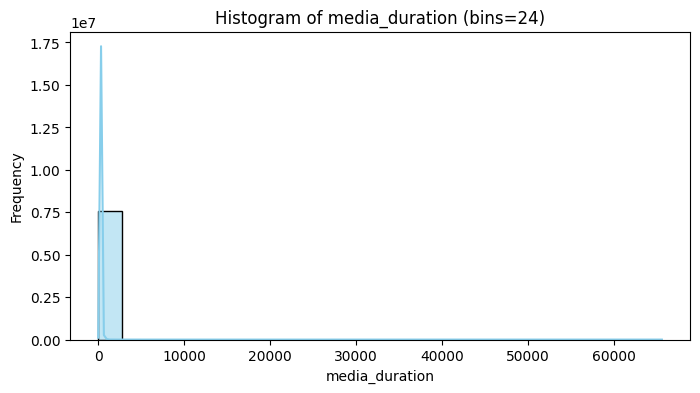

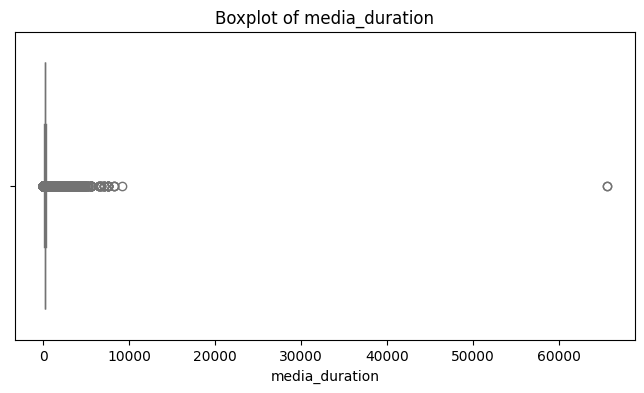

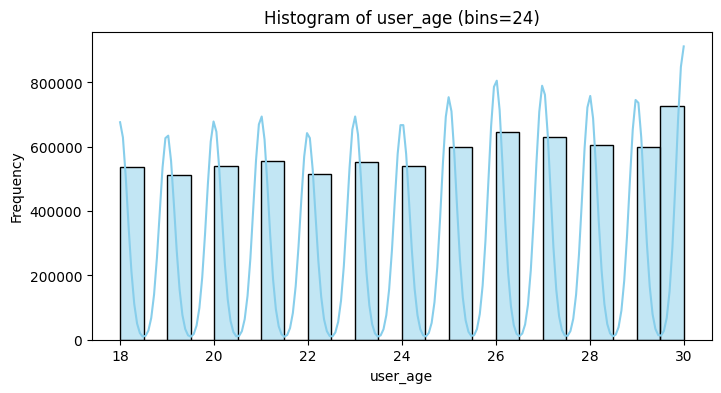

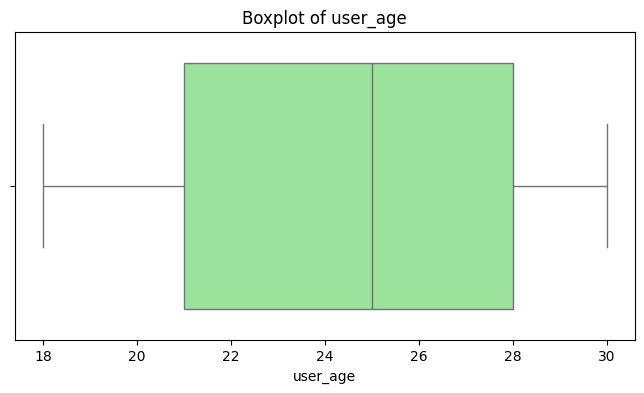

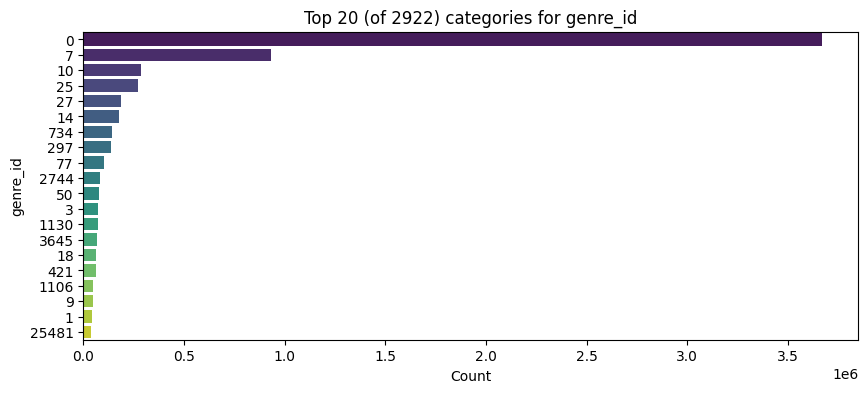

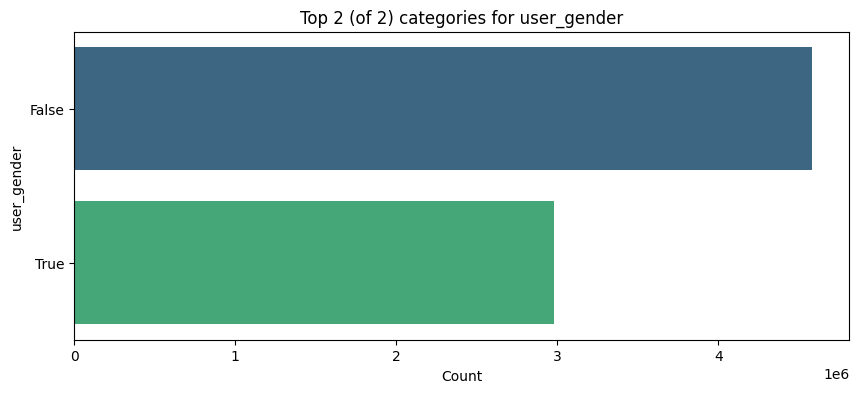

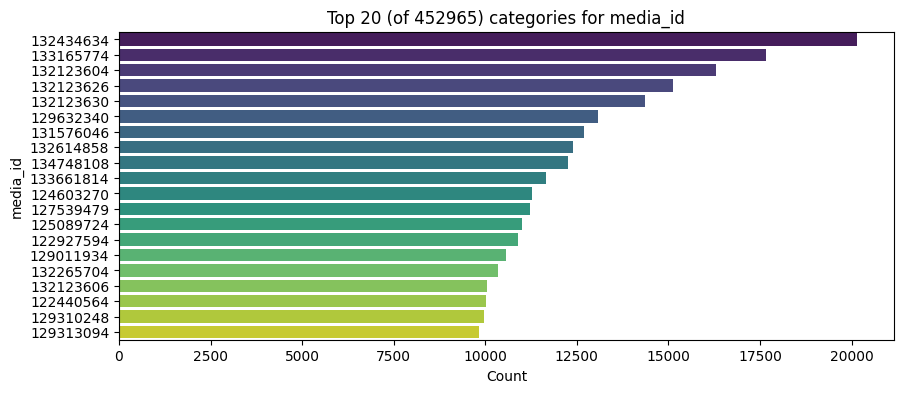

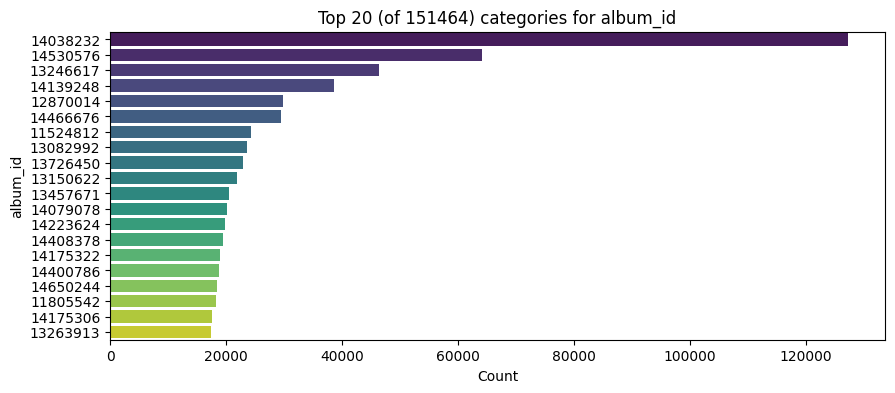

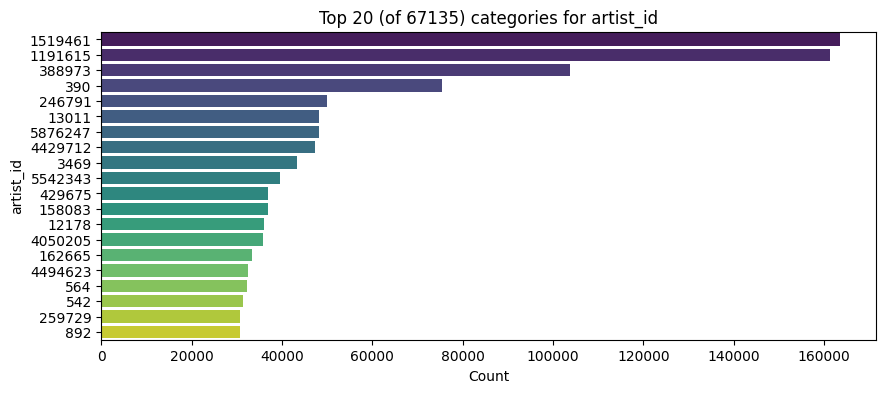

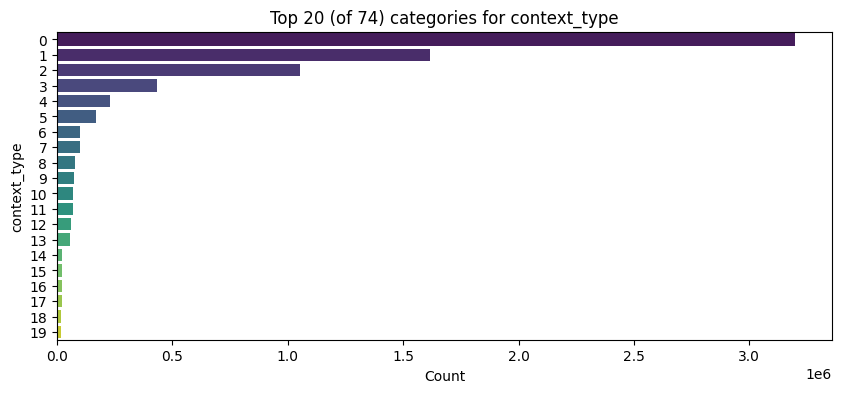

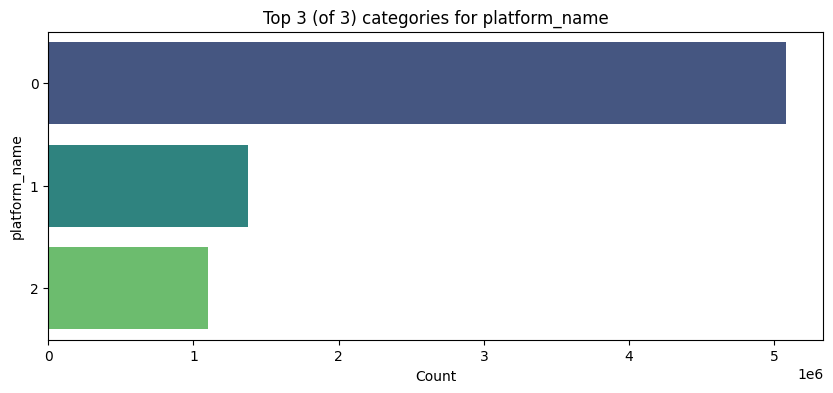

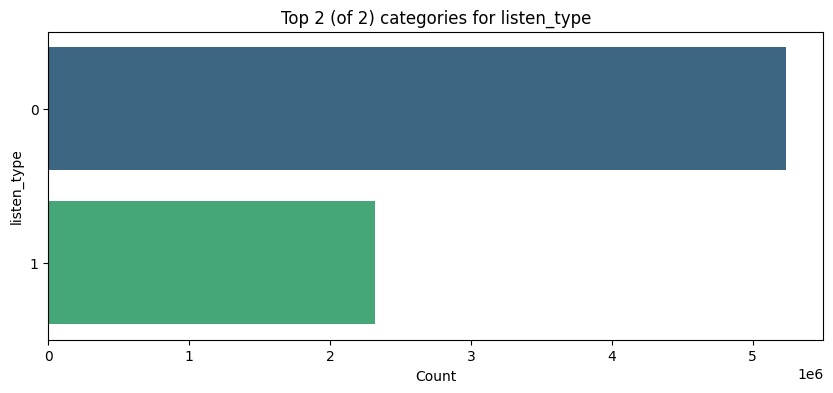

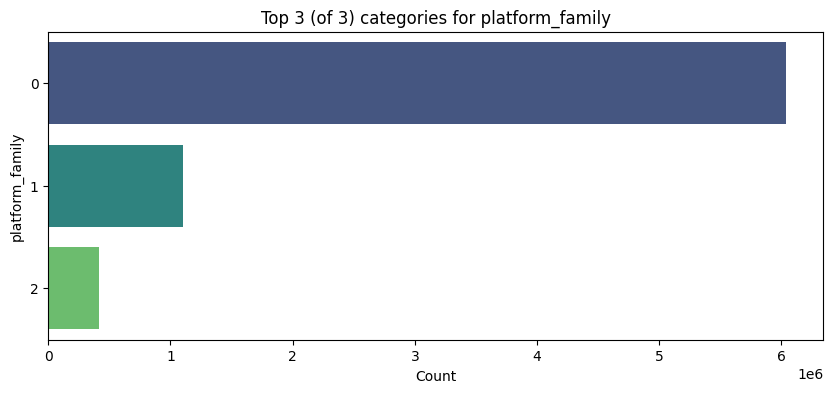

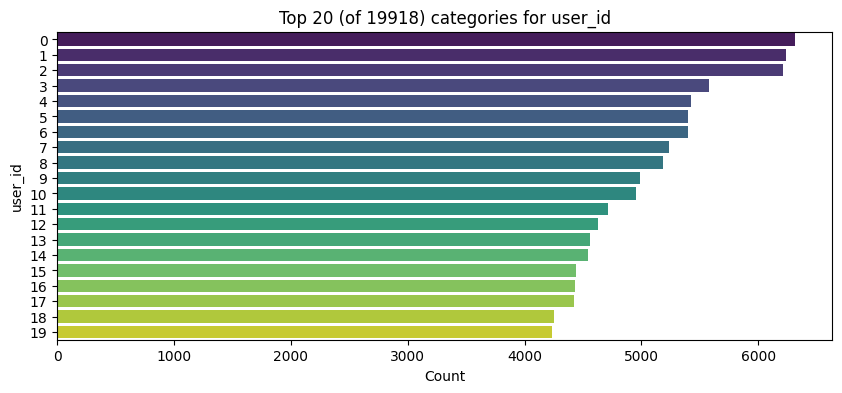

In [ ]:
# Plot numeric features (histograms and boxplots)
eda.plot_numeric_features()
# Plot categorical features
eda.plot_categorical_features()


---

  - `plot_joint_analysis()`: Creates jointplots to explore bivariate relationships and annotates the true correlation

   - **Interpretartion:** The **correlation coefficient ($r$ = 0.03)** indicates **no meaningful linear relationship** between the two variables.



Using a uniform sample of 100000 rows for the plot.


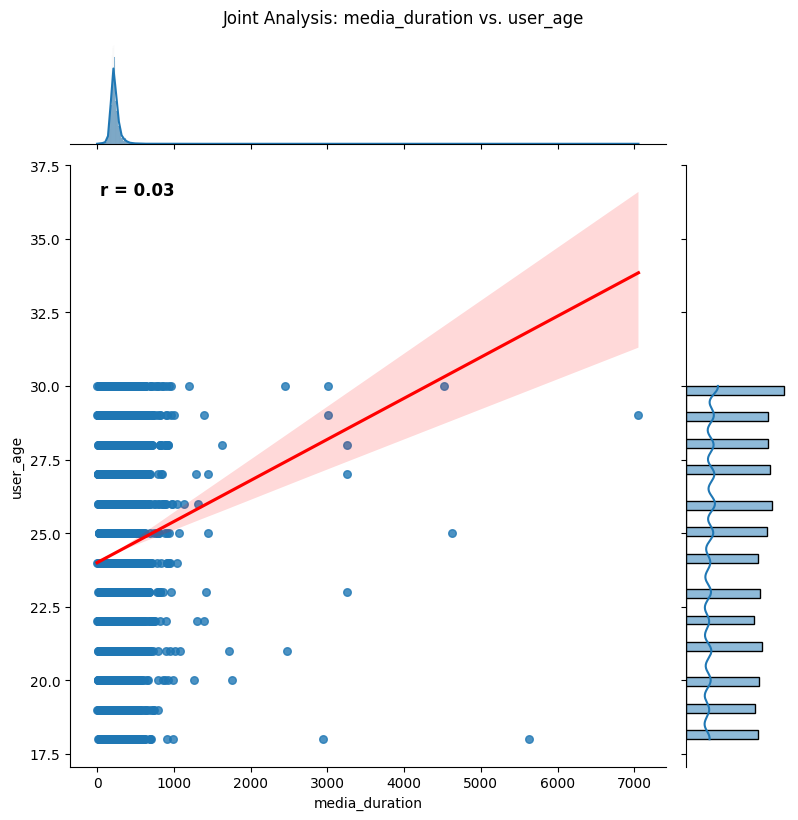

In [ ]:
eda.plot_joint_analysis()

---
- **Temporal Analysis:**
  - `temporal_analysis()`: Aggregates and visualizes time-based trends (e.g., daily/monthly listening counts, weekday patterns, and heatmaps for hour vs. weekday behavior). Applies a cutoff (e.g., from 2015) to focus on relevant data.

- **Interpretation:**

  - **Monthly Trends (2015+):**  
    After filtering out data prior to 2015, the monthly aggregated counts remain very low until mid-2016, then **spike sharply in November 2016** (over 7.4 million listens). This sudden increase could reflect a data coverage change, a platform event, or user growth.

  - **Weekly Patterns:**  
    Listening behavior peaks on **Tuesdays, Wednesdays, and Thursdays**, with relatively lower activity on weekends (Saturday and Sunday). This weekday skew might inform scheduling for content releases.

  - **Hourly Heatmap (log scale):**  
    The highest usage often occurs in the **late morning to midday** and afternoon around 16:00-17:00 on weekdays.

  - **Release Year Distribution:**  
    Most releases cluster in **recent decades**, especially post-2000, indicating a **strong bias toward modern content**. This recency skew may influence user engagement patterns.



Monthly aggregated listening events from 2015 (start year: 1970)
🔴 540 months removed that were before 2015.

listen_date   count
 2015-01-31      23
 2015-02-28       0
 2015-03-31       0
 2015-04-30       1
 2015-05-31       0
 2015-06-30       0
 2015-07-31       1
 2015-08-31       1
 2015-09-30       0
 2015-10-31       0
 2015-11-30       1
 2015-12-31       2
 2016-01-31      55
 2016-02-29       2
 2016-03-31       1
 2016-04-30      25
 2016-05-31       4
 2016-06-30       6
 2016-07-31      78
 2016-08-31     387
 2016-09-30     409
 2016-10-31   40476
 2016-11-30 7440814
 2016-12-31   75748


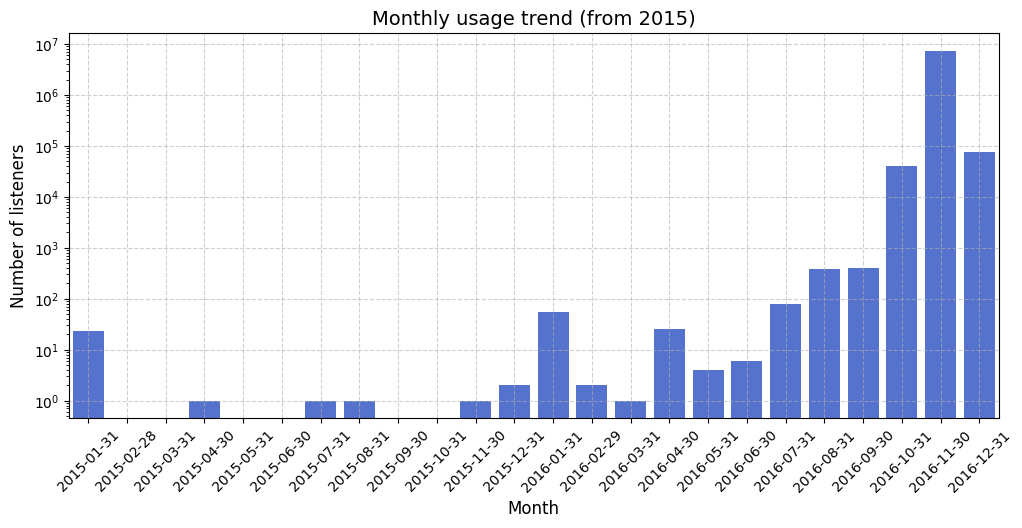

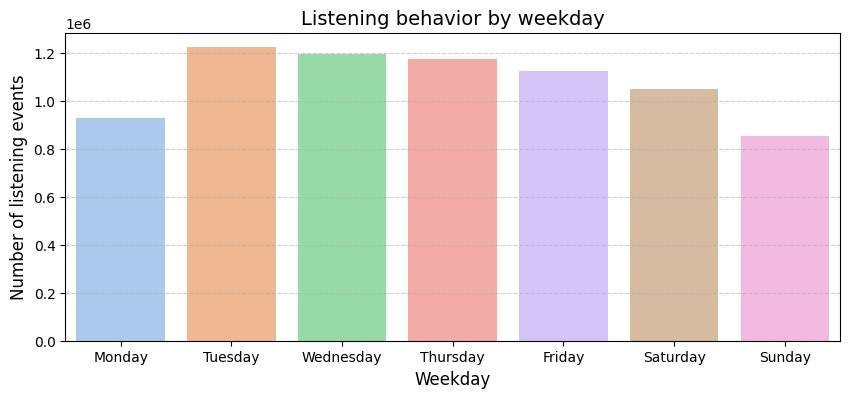

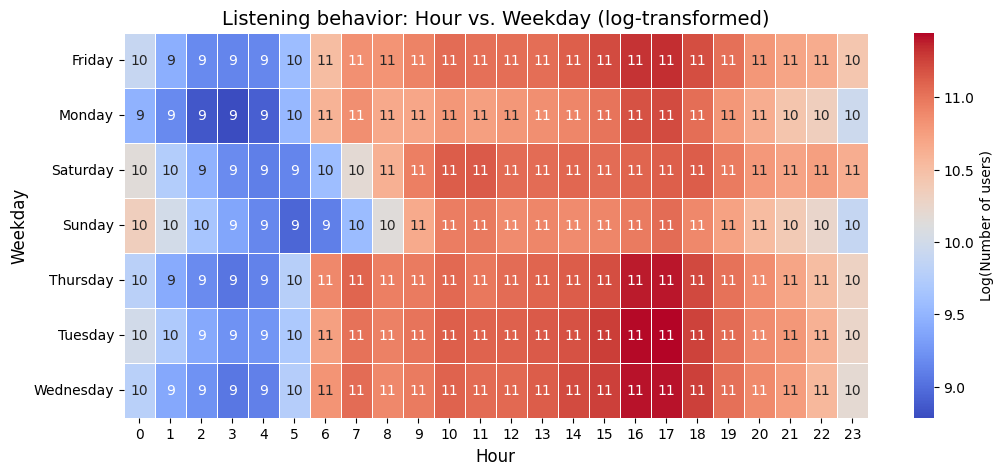

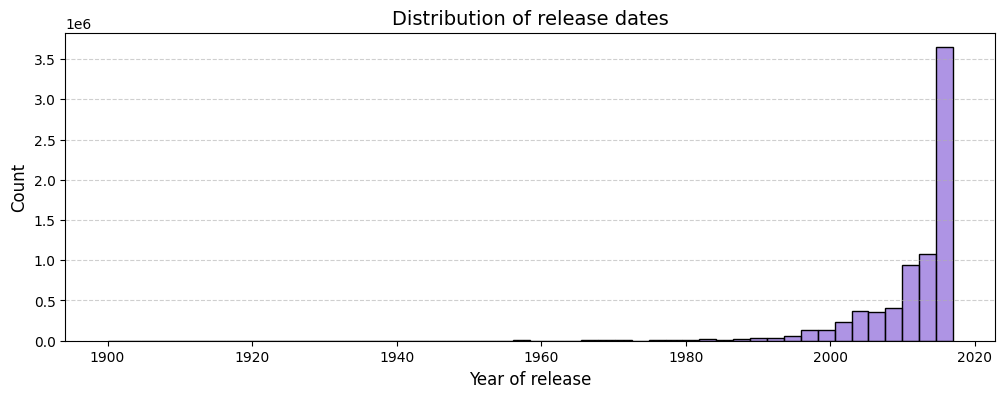

In [ ]:
eda.temporal_analysis()

---
- **Target Variable and Interaction Analysis:**
  - **Distribution of `is_listened`:**  
    - `analyze_target_variable()`: Visualizes the distribution of the target variable (`is_listened`).
    - **Interpretation:** `is_listened` is binary (1 = track listened for over 30 sec, 0 otherwise) with ~5M ones vs. ~3M zeros, indicating an imbalance. This skew should be addressed via re-sampling, class-weight adjustments, or negative sampling to prevent bias in the recommender system.

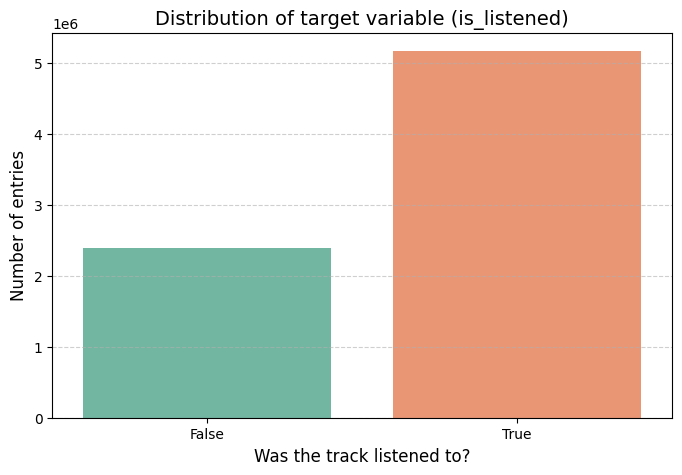

In [ ]:
eda.analyze_target_variable()

  - **Interaction Analysis (User-Level):**
   - **Songs, Albums, and Artists per User:**
      - `interaction_analysis()`: Examines user interactions with songs, albums, and artists using various binning methods (e.g., Rice rule).
      - **Interpretation:** The distributions are **heavily skewed**, with a small number of users consuming a large amount of content. On average, each user listens to **~380 songs**, spanning **~144 albums** by **~109 artists**. The log-scale charts highlight this long-tail pattern, where most users have moderate interaction counts, while a minority are **“power users”** with significantly higher usage.


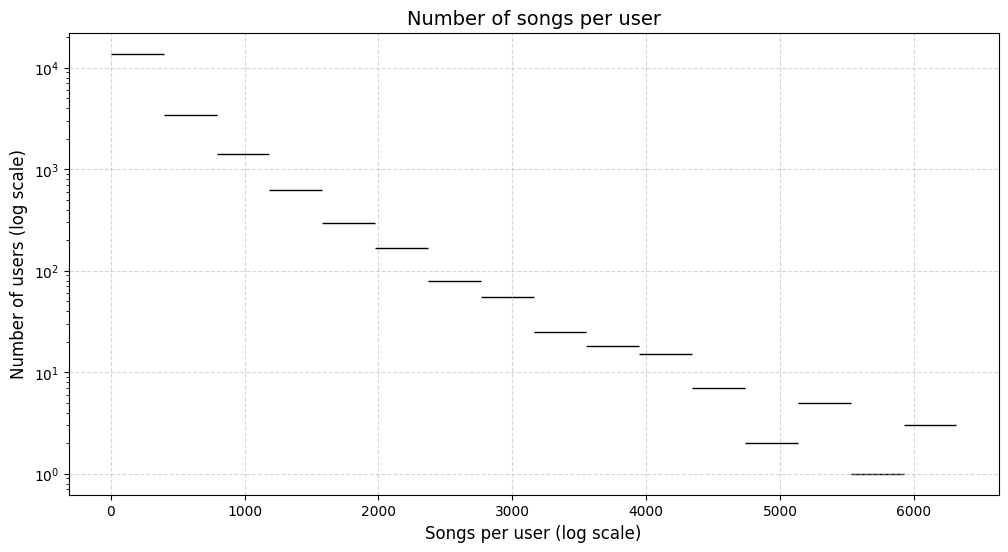

📊 Average songs per user: 379.50


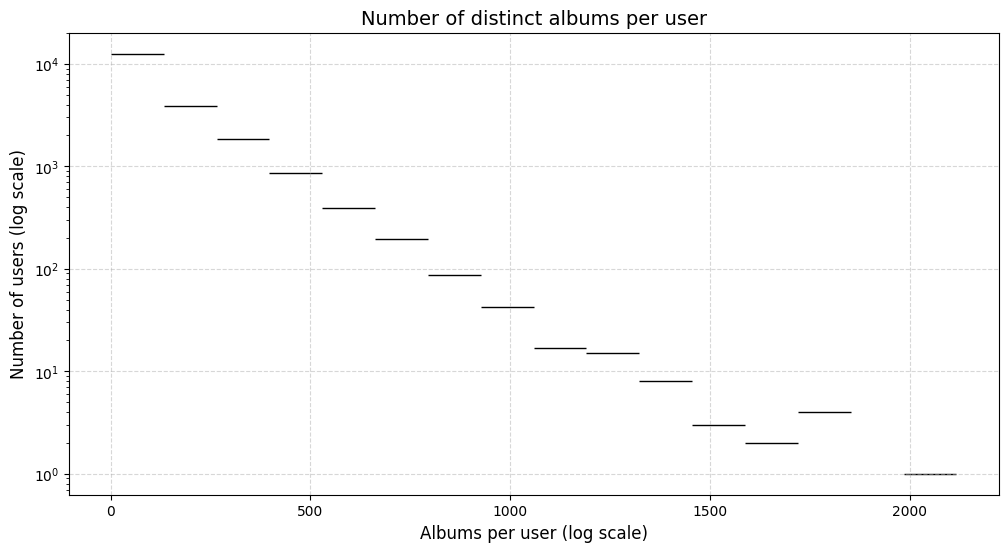

📊 Average albums per user: 144.22


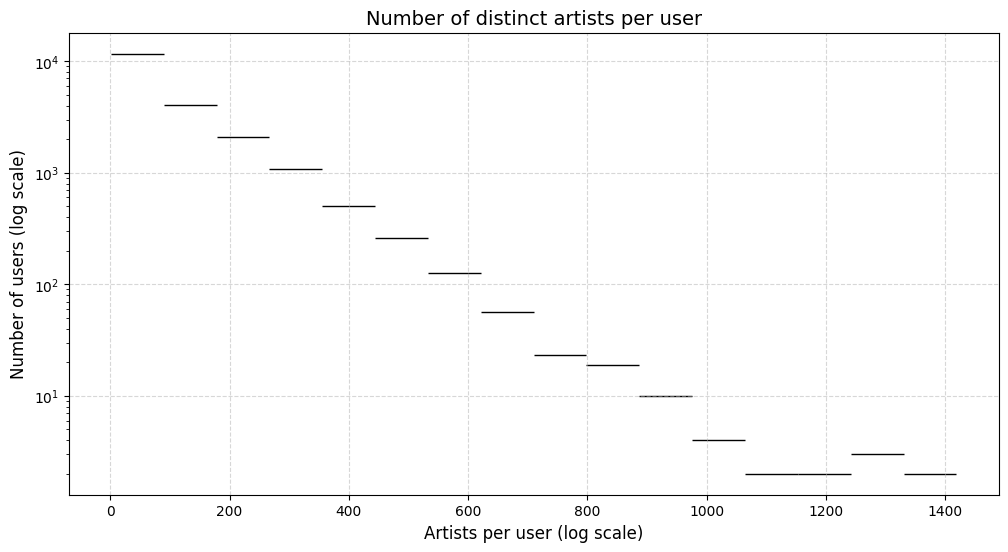

📊 Average artists per user: 109.37


In [ ]:
eda.interaction_analysis(binning_method="rice")

---
**Platform Comparison:**

- `analyze_platform_effect()`: Compares listening behaviors across different streaming platforms.
- **Interpretation:** The bar chart shows **average listening probability** (tracks listened >30s) for each platform. **Platform 2** has the highest rate, followed by **Platform 1** and **Platform 0**, suggesting platform-specific differences in user engagement.

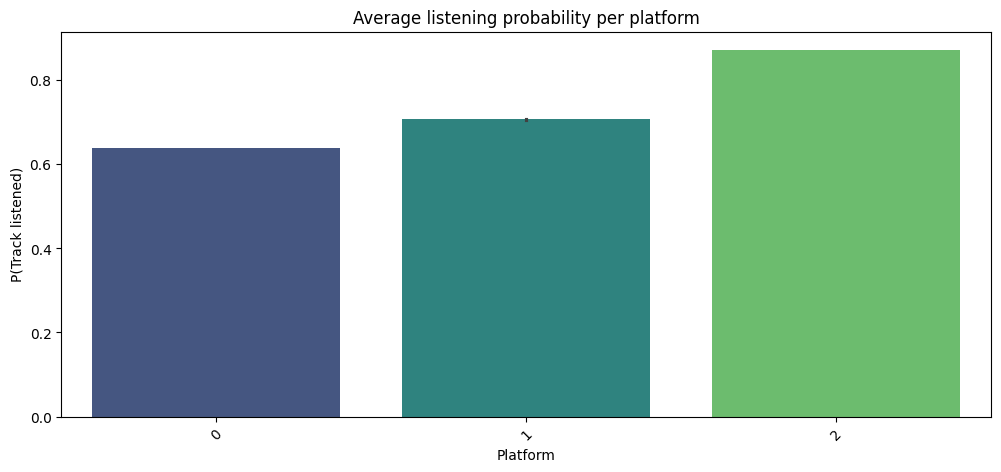

In [ ]:
eda.analyze_platform_effect()

---
**Genre Popularity:**
  - `analyze_genre_effect()`: Evaluates genre popularity by comparing listening probabilities.
  - **Interpretation:** The bar chart shows the top 20 genres by **listening probability**, led by genre `9` at ~0.9, followed by `25`, `10`, etc. “Andere” groups all remaining genres. This variation informs targeted recommendations based on engagement levels.

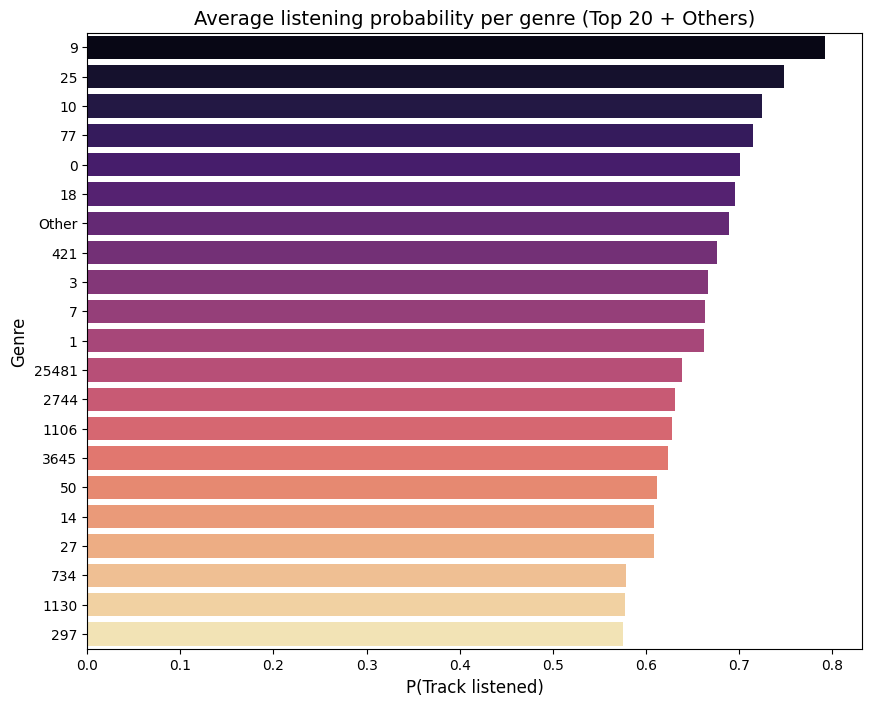

In [ ]:
eda.analyze_genre_effect()


---
**Demographic impact:**
  - `analyze_age_effect()` and `analyze_gender_effect()`: Assess demographic impacts on listening behavior.
  - **Interpretation:**
    - **Age:** The boxplot indicates a slightly higher median age for users who listen (True) vs. those who don’t (False), suggesting **a modest age influence** on listening.

   - **Gender:** The bar chart shows **user_gender = False** has a slightly higher listening probability than **user_gender = True**, indicating **a minor gender-related difference** in engagement.

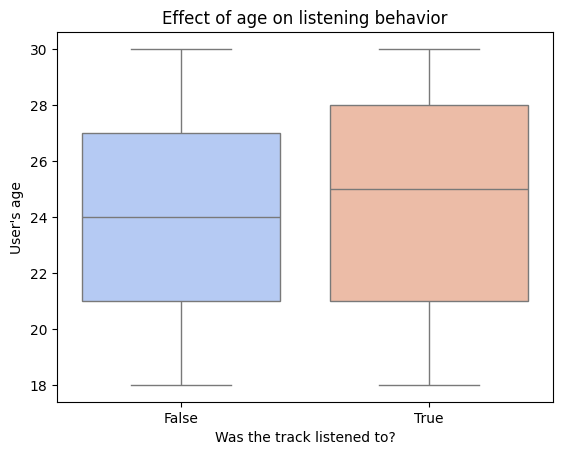

In [ ]:
eda.analyze_age_effect()

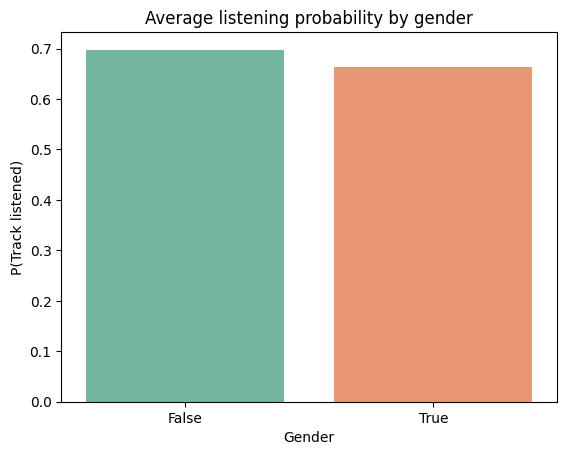

In [ ]:
eda.analyze_gender_effect()

---
**Time of Day & Weekdays:**

  - `analyze_time_effect()`: Studies how listening behavior varies by time of day and weekday.
  - **Interpretation:**
    - **Hourly Patterns:** Listening probabilities are **consistently high** across most hours, with **slight dips** in the **early morning**.

    - **Weekday Patterns:** Probability **remains around 0.65–0.7** all week, indicating **minimal variation** by day.



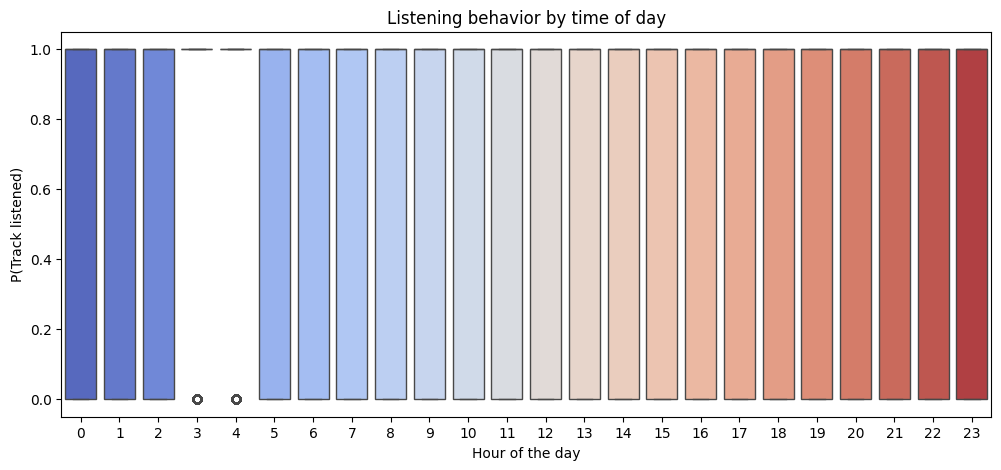

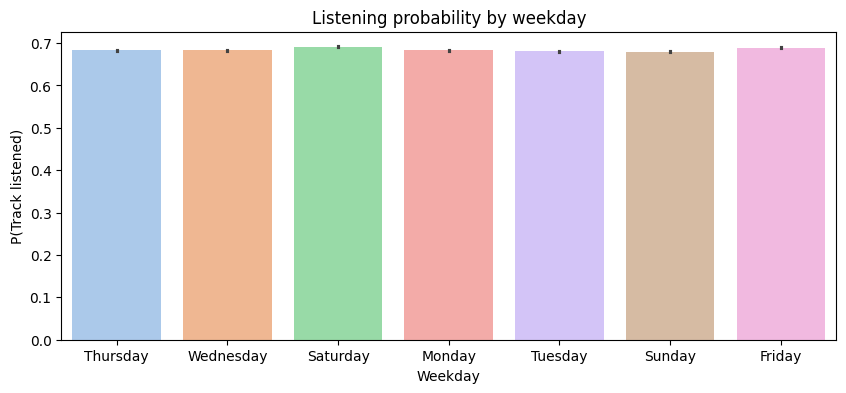

In [ ]:
eda.analyze_time_effect()

---
**Song Duration & Skip Behavior:**
  - `analyze_media_duration_effect()`: Investigates the relationship between song duration and listening/skip behavior.
  - **Interpretation:** The boxplot shows **similar duration distributions** for listened (True) and not listened (False), with **outliers up to 65,535s**. This suggests **song length alone** may not strongly predict skip behavior.


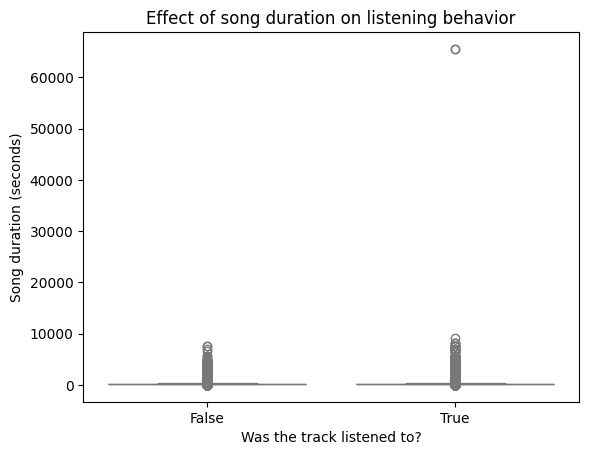

In [ ]:
eda.analyze_media_duration_effect()

**Playlists vs. Albums vs. Radio:**
  - `analyze_context_effect()`: Differentiates between listening contexts (e.g., playlists vs. albums vs. radio).
  - **Interpretation:** The bar chart compares average listening probability across contexts using the **"rocket"** palette. Confidence intervals vary—wider intervals indicate sparser data or higher uncertainty, while narrower ones signal more consistent engagement.












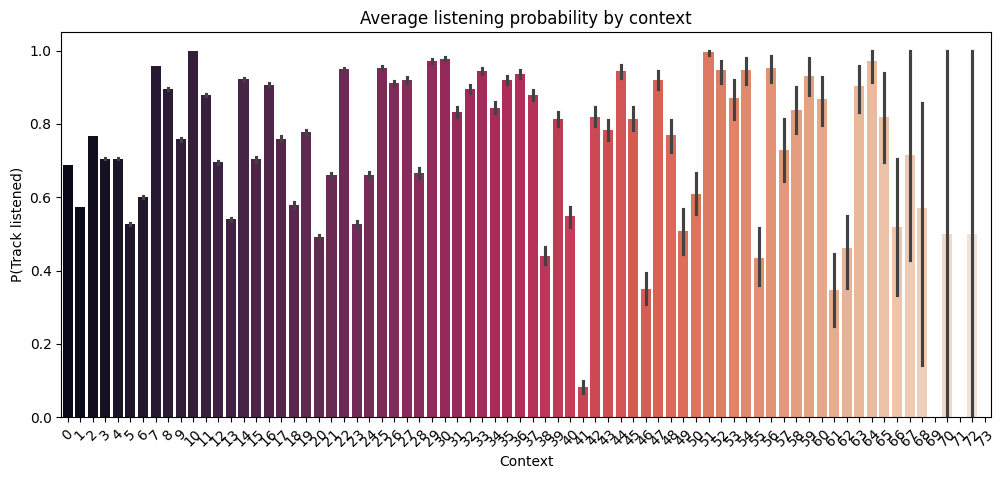

In [ ]:
eda.analyze_context_effect()

### EDA Conclusion and Preprocessing Implications

From our EDA, we observed no missing values and no duplicates, simplifying data cleaning. We will focus on `ts_listen` data from 2015 onward to eliminate older, less relevant entries. However, based on the above findings, several considerations will shape our preprocessing strategy. The **right-skew** in `media_duration` (with outliers up to 65,535 seconds) underscores the need for **robust outlier handling**—either by removing or transforming extreme values. The **heavy-tailed** distributions in `genre_id`, `media_id`, `album_id`, and `artist_id`—where a few categories dominate—suggest using **dimension reduction** or **frequency thresholds** to manage rare categories. Likewise, the **imbalance** in `user_gender` and in the target variable `is_listened` (~5M ones vs. ~3M zeros) calls for **re-sampling** or **negative sampling** techniques to mitigate bias. Our temporal analysis, which revealed **monthly spikes** and a **strong recency** trend (particularly post-2000), points to the value of **time-based features** (e.g., recent popularity windows). Finally, **user-level** insights—such as a minority of “power users” consuming disproportionately more content—highlight the potential of **user-specific metrics** (e.g., top genre, skip rate) in capturing nuanced listening behavior. Incorporating these observations will help ensure a **cleaner, more representative** dataset for robust recommendation model development.


